# RANDOM FOREST TRAINING

M.Á. de Frutos (MAD-2020)


In [1]:
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0


Import Numpy array directly

In [2]:
#PATH='data/Final/'
PATH='data/LEMT/Fusion/'

In [3]:
#Cragamos datos
stopDataset=np.load(PATH+'stop.npy')
noneDataset=np.load(PATH+'none.npy')
aheadDataset=np.load(PATH+ 'ahead.npy')
rightDataset=np.load(PATH+'right.npy')
leftDataset=np.load(PATH+'left.npy')

In [4]:
#Analisis rápido del tamañom NaN etc..
print('STOP:  shape\t', stopDataset[0].shape, '\tLong:',len(stopDataset), '\tNº NaN:', np.isnan(stopDataset).sum())
print('AHEAD: shape\t', aheadDataset[0].shape, '\tLong:',len(aheadDataset),'\tNº NaN:', np.isnan(aheadDataset).sum())
print('RIGHT: shape\t', rightDataset[0].shape, '\tLong:',len(rightDataset),'\tNº NaN:', np.isnan(rightDataset).sum())
print('LEFT:  shape\t', leftDataset[0].shape, '\tLong:',len(leftDataset), '\tNº NaN:', np.isnan(leftDataset).sum())
print('NONE:  shape\t', noneDataset[0].shape, '\tLong:',len(noneDataset), '\tNº NaN:', np.isnan(noneDataset).sum())

STOP:  shape	 (18, 2) 	Long: 1548 	Nº NaN: 0
AHEAD: shape	 (18, 2) 	Long: 1507 	Nº NaN: 0
RIGHT: shape	 (18, 2) 	Long: 1419 	Nº NaN: 0
LEFT:  shape	 (18, 2) 	Long: 1381 	Nº NaN: 0
NONE:  shape	 (18, 2) 	Long: 1372 	Nº NaN: 0


## Pre-Procesamiento previo
 - 1) Añadimos etiquetas
 - 2) Generamos único Datset
 - 3) Mezclamos aleatoriamente
 - 4) Divido conjunto Train/Test
 - 5) Serializo
 

Necesitamos añadir una etiqueta a cada tipo de datos antes de juntarlos todos.

Usaremos el siguiente código:

`0` -> `STOP`

`1` -> `AHEAD`

`2` -> `RIGHT`

`3` -> `LEFT`

`4` -> `NONE`


In [5]:
#Añadimos array de ETIQUETAS
labels = np.zeros(len(stopDataset))                        #Añadimos tantos 0 como datos de STOP
labels = np.append(labels, np.full((len(aheadDataset)), 1)) #Añadimos tantos 4 como datos de AHEAD
labels = np.append(labels, np.full((len(rightDataset)), 2)) #Añadimos tantos 1 como datos de RIGHT
labels = np.append(labels, np.full((len(leftDataset)), 3)) #Añadimos tantos 2 como datos de LEFT
labels = np.append(labels, np.full((len(noneDataset)), 4)) #Añadimos tantos 3 como datos de NONE


print(labels) #Mostramos todas las etiquetas
print("%i total examples for training." % len(labels)) #Y su suma total

[0. 0. 0. ... 4. 4. 4.]
7227 total examples for training.


In [6]:
#Juntamos todos los datos en un único dataset
dataset = np.append(stopDataset, aheadDataset, axis=0)
dataset = np.append(dataset, rightDataset, axis=0)
dataset = np.append(dataset, leftDataset, axis=0)
dataset = np.append(dataset, noneDataset, axis=0)

print("Tamaño Dataset:", len(dataset))

Tamaño Dataset: 7227


In [7]:
#Mezclados los datos manteniendo una correspondencia entre etiqueta y feature
from sklearn.utils import shuffle

X, y = shuffle(dataset, labels)
print(y) 

[1. 4. 0. ... 0. 0. 2.]


In [8]:
#Comvertimos etiquetas a tipo Categórico 

N_Clases= 5 #Nº de clases 

y = tf.keras.utils.to_categorical(y, N_Clases)
print("e.g.: ",y[0])



e.g.:  [0. 1. 0. 0. 0.]


In [9]:
#Separo un 20% de datos para Test
from sklearn.model_selection import train_test_split #Divido los datos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=50) 


In [10]:
#Ajustamos tamaño del array para Red neuronal
print("Entrada:")
print(" Train:", X_train.shape, len (y_train))
print(" Test:", X_test.shape, len (y_test))

#Convertimos 18 keypoints *2 coordenadas X,y -> 36
X_train = X_train.reshape(len(X_train), 36) 
X_test = X_test.reshape(len(X_test), 36) 

print("\nSalida:")
print(" Train:", X_train.shape, len (y_train))
print(" Test:", X_test.shape, len (y_test))


Entrada:
 Train: (5781, 18, 2) 5781
 Test: (1446, 18, 2) 1446

Salida:
 Train: (5781, 36) 5781
 Test: (1446, 36) 1446


### Func. Gráficas:

In [11]:
#Gráficas    
# Pinta MATRIZ de CONFUSIÓN- Código extraideo de la web de SKLEARN
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='RF - CONFUSION MATRIX',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

### RANDOM FOREST IMPLEMENTATION

Calculating RMSE for min_samples_leaf:1, 2, 3, 4, 5, 6, 7, 8, 9, 

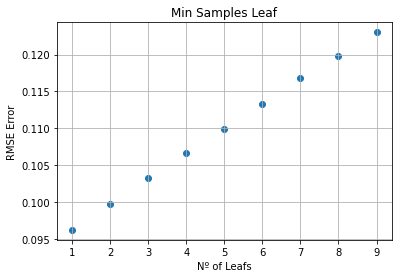

Mejor "min_samples_leaf" es: 1


In [12]:
#Buscar el mejor número minimo de hojas para random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

min_samples_leaf = range(1, 10)
all_rmse_RFR = []

print("Calculating RMSE for min_samples_leaf:", end = '')

for min_leafs in min_samples_leaf:
    print(f'{min_leafs}, ', end = '')
    dec_Tree = RandomForestRegressor(random_state = 0, min_samples_leaf = min_leafs)
    dec_Tree.fit(X_train, y_train)
    y_predicha = dec_Tree.predict(X_test)
    all_rmse_RFR.append(sqrt(mean_squared_error(y_test, y_predicha)))

plt.close()
plt.grid(True)
plt.scatter(min_samples_leaf, all_rmse_RFR)
plt.title('Min Samples Leaf')
plt.ylabel('RMSE Error')
plt.xlabel('Nº of Leafs')
plt.savefig('RFimages/Leaf.png')
plt.show()

best_forest_min_samples_leaf = min_samples_leaf[all_rmse_RFR.index(min(all_rmse_RFR))]
print(f'Mejor "min_samples_leaf" es: {best_forest_min_samples_leaf}')

Calculating RMSE for min_samples_leaf:1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

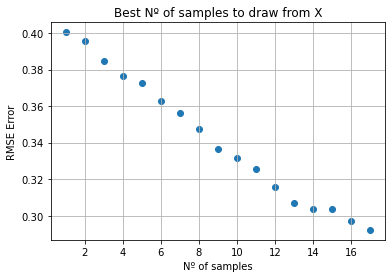

Mejor "min_samples_leaf" es: 17


In [13]:
#Buscar el mejor número de variables por cada corte random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

min_samples_leaf = range(1, 18)
all_rmse_RFR = []

print("Calculating RMSE for min_samples_leaf:", end = '')

for min_leafs in min_samples_leaf:
    print(f'{min_leafs}, ', end = '')
    dec_Tree = RandomForestRegressor(random_state = 0, max_samples=min_leafs)
    dec_Tree.fit(X_train, y_train)
    y_predicha = dec_Tree.predict(X_test)
    all_rmse_RFR.append(sqrt(mean_squared_error(y_test, y_predicha)))

plt.close()
plt.grid(True)
plt.scatter(min_samples_leaf, all_rmse_RFR)
plt.title('Best Nº of samples to draw from X')
plt.ylabel('RMSE Error')
plt.xlabel('Nº of samples')
plt.savefig('RFimages/Samples.png')
plt.show()

best_forest_min_samples_leaf = min_samples_leaf[all_rmse_RFR.index(min(all_rmse_RFR))]
print(f'Mejor "min_samples_leaf" es: {best_forest_min_samples_leaf}')

Calculating RMSE for n_estimators:1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

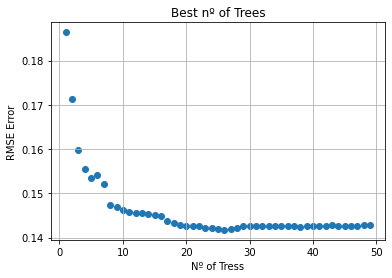

Mejor "Nº de árboles" es: 26


In [14]:
#Buscar el mejor número de arboles con el mejor número minimo de hojas obtenidas en el apartado anterior
from sklearn.ensemble import RandomForestRegressor

n_estimators = range(1, 50, 1)
all_rmse_RFR = []
print("Calculating RMSE for n_estimators:", end = '')
for estimator in n_estimators:
    print(f'{estimator}, ', end = '')
    dec_Tree = RandomForestRegressor(random_state = 0, n_estimators = estimator, min_samples_leaf = best_forest_min_samples_leaf)
    dec_Tree.fit(X_train, y_train)
    y_predicha = dec_Tree.predict(X_test)
    all_rmse_RFR.append(sqrt(mean_squared_error(y_test, y_predicha)))
    

plt.close()
plt.scatter(n_estimators, all_rmse_RFR)
plt.title('Best nº of Trees')
plt.grid(True)
plt.ylabel('RMSE Error')
plt.xlabel('Nº of Tress')
plt.savefig('RFimages/Trees.png')
plt.show()

best_forest_entimator = n_estimators[all_rmse_RFR.index(min(all_rmse_RFR))]
print(f'Mejor "Nº de árboles" es: {best_forest_entimator}')

In [23]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rand_forest = RandomForestRegressor(random_state=0, n_estimators=26)
rand_forest.fit(X_train,y_train);
y_predicha = rand_forest.predict(X_test)


rmse_RFR = sqrt(mean_squared_error(y_test, y_predicha))
r_RFR = r2_score(y_test, y_predicha)

print("RMSE RandomForestRegressor:", rmse_RFR)
print("R^2 score RandomForestRegressor:",r_RFR)

RMSE RandomForestRegressor: 0.09641787348829801
R^2 score RandomForestRegressor: 0.9427088048621807


Feature ranking:
1. Feature 19 (0.309526)
2. Feature 10 (0.103673)
3. Feature 18 (0.099532)
4. Feature 20 (0.087471)
5. Feature 27 (0.048864)
6. Feature 15 (0.042107)
7. Feature 21 (0.033379)
8. Feature 5 (0.030212)
9. Feature 3 (0.029455)
10. Feature 13 (0.024038)
11. Feature 29 (0.018896)
12. Feature 11 (0.016902)
13. Feature 17 (0.015001)
14. Feature 25 (0.014147)
15. Feature 12 (0.012039)
16. Feature 1 (0.009540)
17. Feature 8 (0.009350)
18. Feature 23 (0.008229)


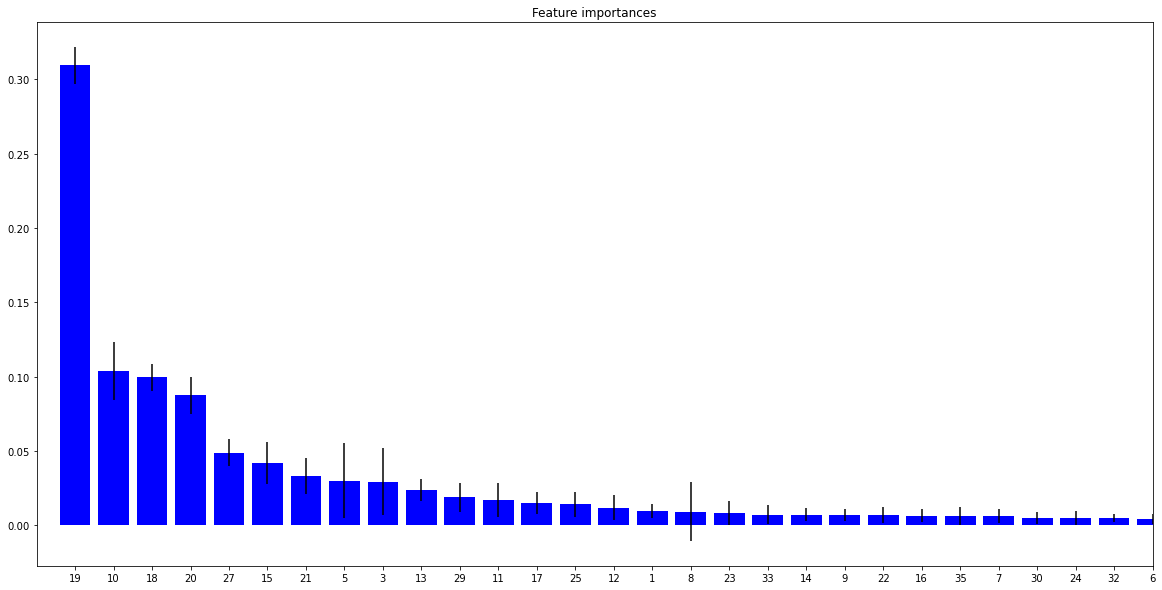

In [24]:
importances = rand_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]-8])
plt.savefig('RFimages/Importance.png')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       314
           1       0.96      0.96      0.96       309
           2       0.96      0.99      0.97       265
           3       0.97      0.95      0.96       293
           4       1.00      0.98      0.99       265

    accuracy                           0.97      1446
   macro avg       0.97      0.97      0.97      1446
weighted avg       0.97      0.97      0.97      1446



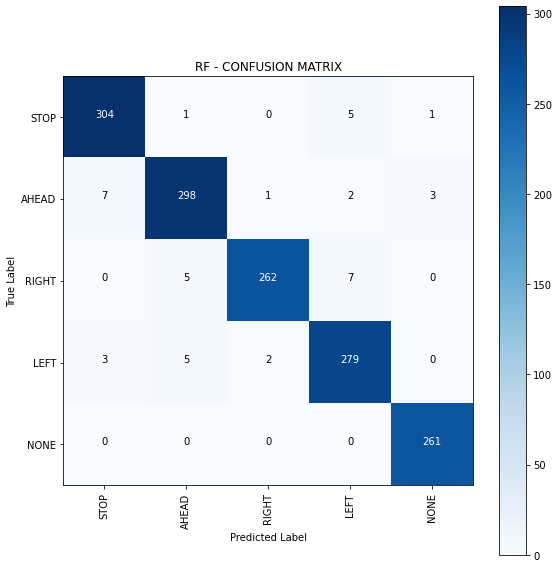

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

MAP_POSES = { 0: 'STOP', 1: 'AHEAD', 2: 'RIGHT',3: 'LEFT', 4: 'NONE'}

# Predict the values from the validation dataset
Y_pred = rand_forest.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = list(MAP_POSES.values()))

print(classification_report(Y_pred_classes, Y_true))

In [18]:

#Importamos las librerias para mostrar el arbol
from sklearn.tree import export_graphviz
from IPython.display import display
from sklearn import tree
import graphviz

#Seleccionamos el primer árbol para verlo por pantalla
forest_regressor = rand_forest.estimators_[0]
#Exportamos el modelo a archivo .dot
with open("tree_output.dot", 'w') as f:
     f = tree.export_graphviz(forest_regressor,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              rounded = True,
                              filled= True )

with open("tree_output.dot") as f:
    dot_graph = f.read()
#mostramos el arbol  
##display(graphviz.Source(dot_graph))


## Save and Load model

In [19]:
import pickle

In [20]:
#Save Model
filename = 'model_fusion_rand_forest.sav'
pickle.dump(rand_forest, open(filename, 'wb'))

In [21]:
#Load Model
#filename = 'model_fusion_rand_forest.sav'
#loaded_model = pickle.load(open(filename, 'rb'))

In [22]:
#result = loaded_model.score(X_test, y_test)
#print(result)